<a href="https://colab.research.google.com/github/OtolaHan/Otola_Han_KAAN/blob/main/1_laba_RMSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2025-02-15 05:55:10--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [      <=>           ] 201.24M  38.1MB/s    in 5.6s    

2025-02-15 05:55:16 (35.8 MB/s) - ‘data.txt.zip’ saved [211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [5]:
# Задание 0.
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

scaler = StandardScaler()

In [6]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [7]:
set_random_seed(42)

In [12]:
# 1) Предобработка данных: обучаем StandardScaler на обучающей выборке
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Обучаем Ridge регрессию (параметры по умолчанию)
ridge_model = Ridge(random_state=42)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print("Ridge Regression RMSE:", rmse_ridge)
# Константное предсказание: лучшая константа с точки зрения RMSE – это среднее значение целевой переменной на обучающей выборке
const_prediction = np.mean(y_train)
y_pred_const = np.full_like(y_test, fill_value=const_prediction, dtype=np.float64)
rmse_const = np.sqrt(mean_squared_error(y_test, y_pred_const))
print("Constant (mean) predictor RMSE:", rmse_const)

Ridge Regression RMSE: 9.510160820470436
Constant (mean) predictor RMSE: 10.85246390513634


Epoch 1/10, Train RMSE: 1998.3940, Test RMSE: 1958.5328
Epoch 2/10, Train RMSE: 1958.4268, Test RMSE: 1919.3611
Epoch 3/10, Train RMSE: 1919.2591, Test RMSE: 1880.9732
Epoch 4/10, Train RMSE: 1880.8747, Test RMSE: 1843.3533
Epoch 5/10, Train RMSE: 1843.2582, Test RMSE: 1806.4861
Epoch 6/10, Train RMSE: 1806.3940, Test RMSE: 1770.3564
Epoch 7/10, Train RMSE: 1770.2672, Test RMSE: 1734.9496
Epoch 8/10, Train RMSE: 1734.8628, Test RMSE: 1700.2508
Epoch 9/10, Train RMSE: 1700.1667, Test RMSE: 1666.2465
Epoch 10/10, Train RMSE: 1666.1645, Test RMSE: 1632.9223


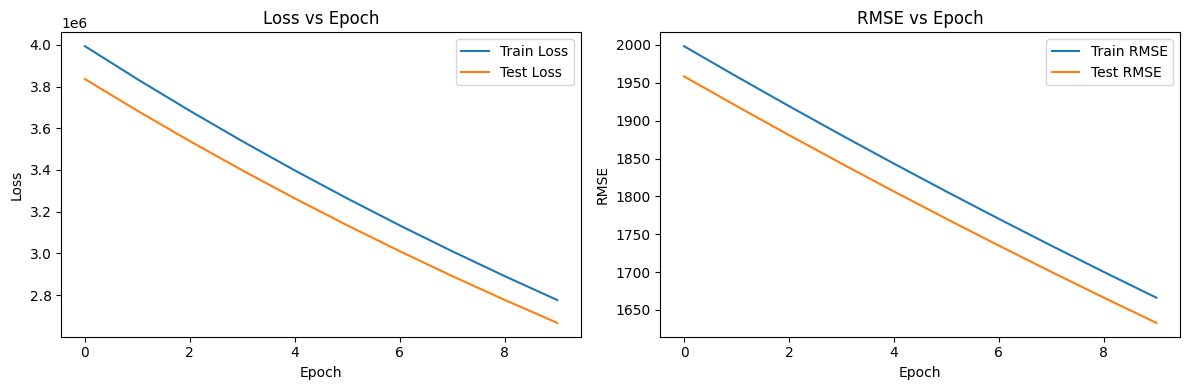

In [9]:
# Задание 1
class LinearRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

# Подготовка данных
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

# Создание модели
model = LinearRegression(X_train.shape[1])

# Параметры обучения
learning_rate = 0.01
n_epochs = 10

# Списки для хранения метрик
train_losses = []
test_losses = []
train_rmse = []
test_rmse = []

# Цикл обучения
for epoch in range(n_epochs):
    # Обучение
    model.train()
    # Прямой проход
    y_pred = model(X_train_tensor)
    # Вычисление MSE вручную
    loss = torch.mean((y_pred - y_train_tensor) ** 2)

    # Обратное распространение
    model.zero_grad()
    loss.backward()

    # Обновление весов вручную
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Сохранение метрик
    train_losses.append(loss.item())

    # Оценка на тестовой выборке
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_tensor)
        test_loss = torch.mean((test_pred - y_test_tensor) ** 2)
        test_losses.append(test_loss.item())

        # Подсчет RMSE
        train_rmse.append(np.sqrt(train_losses[-1]))
        test_rmse.append(np.sqrt(test_losses[-1]))

    print(f'Epoch {epoch+1}/{n_epochs}, Train RMSE: {train_rmse[-1]:.4f}, Test RMSE: {test_rmse[-1]:.4f}')

# Построение графиков
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_rmse, label='Train RMSE')
plt.plot(test_rmse, label='Test RMSE')
plt.title('RMSE vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 10/100
Train RMSE: 0.4492
Test RMSE: 0.5157
Epoch 20/100
Train RMSE: 0.3255
Test RMSE: 0.3624
Epoch 30/100
Train RMSE: 0.2096
Test RMSE: 0.2579
Epoch 40/100
Train RMSE: 0.1959
Test RMSE: 0.2136
Epoch 50/100
Train RMSE: 0.1647
Test RMSE: 0.1823
Epoch 60/100
Train RMSE: 0.3208
Test RMSE: 0.3230
Epoch 70/100
Train RMSE: 0.2099
Test RMSE: 0.2146
Epoch 80/100
Train RMSE: 0.1382
Test RMSE: 0.1543
Epoch 90/100
Train RMSE: 0.1334
Test RMSE: 0.1451
Epoch 100/100
Train RMSE: 0.1305
Test RMSE: 0.1432


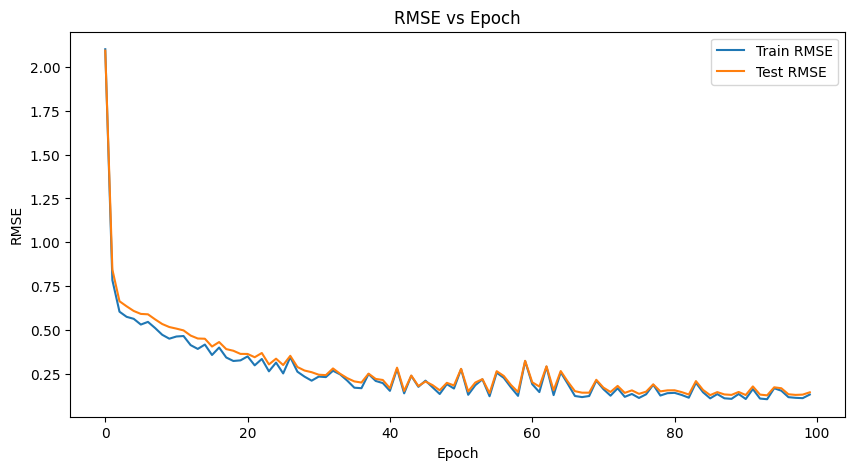

In [28]:
# Задание 2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Создаем кастомный датасет
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Предобработка данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создаем даталоадеры
batch_size = 32
train_set = CustomDataset(X_train_scaled, y_train)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = CustomDataset(X_test_scaled, y_test)
test_loader = DataLoader(test_set, batch_size=batch_size)

# Определяем модель
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Инициализация модели, оптимизатора и функции потерь
model = NeuralNetwork(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

def train(model, optimizer, criterion, train_loader, test_loader):
    n_epochs = 100
    train_losses = []
    test_losses = []
    train_rmse = []
    test_rmse = []

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.reshape(-1, 1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Вычисление метрик на всем датасете
        model.eval()
        with torch.no_grad():
            train_preds = []
            train_true = []
            for X_batch, y_batch in train_loader:
                pred = model(X_batch)
                train_preds.extend(pred.numpy())
                train_true.extend(y_batch.numpy())

            test_preds = []
            test_true = []
            for X_batch, y_batch in test_loader:
                pred = model(X_batch)
                test_preds.extend(pred.numpy())
                test_true.extend(y_batch.numpy())

            train_rmse_val = np.sqrt(mean_squared_error(train_true, train_preds))
            test_rmse_val = np.sqrt(mean_squared_error(test_true, test_preds))

            train_rmse.append(train_rmse_val)
            test_rmse.append(test_rmse_val)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{n_epochs}')
            print(f'Train RMSE: {train_rmse_val:.4f}')
            print(f'Test RMSE: {test_rmse_val:.4f}')

    # Построение графиков
    plt.figure(figsize=(10, 5))
    plt.plot(train_rmse, label='Train RMSE')
    plt.plot(test_rmse, label='Test RMSE')
    plt.title('RMSE vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

def test(model, criterion, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            pred = model(X_batch)
            predictions.extend(pred.numpy().reshape(-1))
    return torch.tensor(predictions)

# Запускаем обучение
train(model, optimizer, criterion, train_loader, test_loader)

Epoch  1 | Train MSE: 22.5613 | Test MSE: 23.5146 | Test RMSE: 4.8492
Epoch  2 | Train MSE: 22.4713 | Test MSE: 23.4207 | Test RMSE: 4.8395
Epoch  3 | Train MSE: 22.3816 | Test MSE: 23.3272 | Test RMSE: 4.8298
Epoch  4 | Train MSE: 22.2923 | Test MSE: 23.2341 | Test RMSE: 4.8202
Epoch  5 | Train MSE: 22.2033 | Test MSE: 23.1413 | Test RMSE: 4.8105
Epoch  6 | Train MSE: 22.1147 | Test MSE: 23.0489 | Test RMSE: 4.8009
Epoch  7 | Train MSE: 22.0265 | Test MSE: 22.9568 | Test RMSE: 4.7913
Epoch  8 | Train MSE: 21.9386 | Test MSE: 22.8652 | Test RMSE: 4.7818
Epoch  9 | Train MSE: 21.8510 | Test MSE: 22.7738 | Test RMSE: 4.7722
Epoch 10 | Train MSE: 21.7638 | Test MSE: 22.6829 | Test RMSE: 4.7627


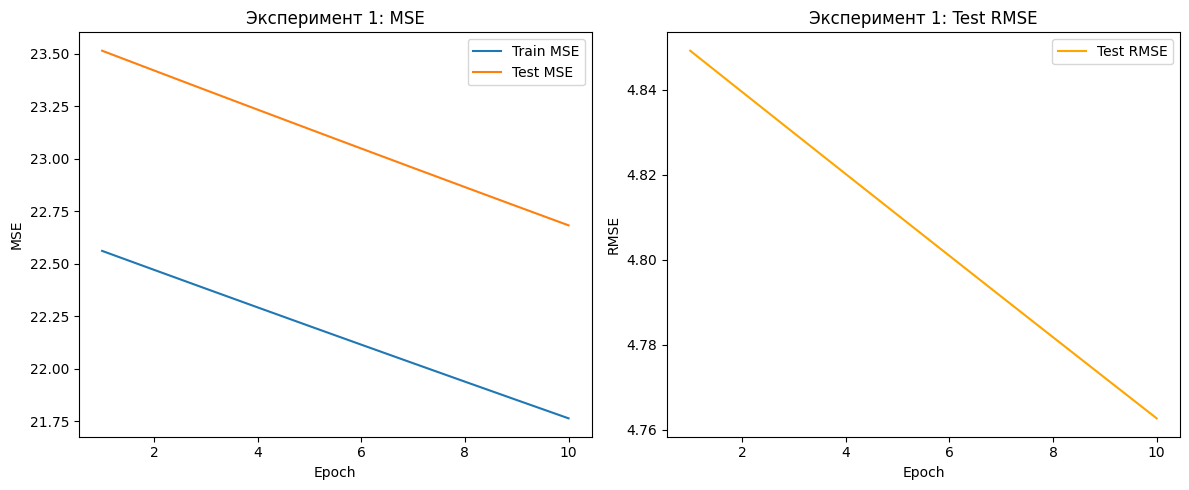

In [27]:
# Задание 3
# Эксперимент 1: Базовая линейная регрессия на PyTorch
import torch
from torch import nn
import numpy as np
import random
import matplotlib.pyplot as plt

# Фиксируем random seed для воспроизводимости
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

# Допустим, X_train_scaled и X_test_scaled уже подготовлены (после StandardScaler)
# Для эксперимента берём срез данных
n_train_samples = 10000
n_test_samples  = 5000
X_train_subset = X_train_scaled[:n_train_samples]
y_train_subset = y_train[:n_train_samples]
X_test_subset  = X_test_scaled[:n_test_samples]
y_test_subset  = y_test[:n_test_samples]

device = "cuda" if torch.cuda.is_available() else "cpu"
X_train_tensor = torch.tensor(X_train_subset, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train_subset, dtype=torch.float32, device=device)
X_test_tensor  = torch.tensor(X_test_subset, dtype=torch.float32, device=device)
y_test_tensor  = torch.tensor(y_test_subset, dtype=torch.float32, device=device)

# Определяем модель – один линейный слой
model = nn.Linear(X_train_tensor.shape[1], 1).to(device)

# Гиперпараметры
learning_rate = 1e-3
num_epochs = 10

train_losses = []
test_losses = []
test_rmse = []

def mse_loss(pred, target):
    return torch.mean((pred - target)**2)

for epoch in range(num_epochs):
    model.train()
    predictions = model(X_train_tensor).squeeze()
    loss = mse_loss(predictions, y_train_tensor)
    loss.backward()

    with torch.no_grad():
      for param in model.parameters():
            param -= learning_rate * param.grad
            param.grad.zero_()

    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_tensor).squeeze()
        loss_test = mse_loss(test_pred, y_test_tensor)
        test_losses.append(loss_test.item())
        rmse = torch.sqrt(loss_test)
        test_rmse.append(rmse.item())

    print(f"Epoch {epoch+1:2d} | Train MSE: {loss.item():.4f} | Test MSE: {loss_test.item():.4f} | Test RMSE: {rmse.item():.4f}")

# График результатов
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train MSE")
plt.plot(epochs, test_losses, label="Test MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Эксперимент 1: MSE")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, test_rmse, label="Test RMSE", color="orange")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Эксперимент 1: Test RMSE")
plt.legend()
plt.tight_layout()
plt.show()


Epoch  1 | Train MSE: 22.5613 | Test MSE: 23.5617 | Test RMSE: 4.8540
Epoch  2 | Train MSE: 22.5163 | Test MSE: 23.5147 | Test RMSE: 4.8492
Epoch  3 | Train MSE: 22.4713 | Test MSE: 23.4677 | Test RMSE: 4.8443
Epoch  4 | Train MSE: 22.4265 | Test MSE: 23.4208 | Test RMSE: 4.8395
Epoch  5 | Train MSE: 22.3817 | Test MSE: 23.3740 | Test RMSE: 4.8347
Epoch  6 | Train MSE: 22.3370 | Test MSE: 23.3273 | Test RMSE: 4.8298
Epoch  7 | Train MSE: 22.2924 | Test MSE: 23.2808 | Test RMSE: 4.8250
Epoch  8 | Train MSE: 22.2479 | Test MSE: 23.2342 | Test RMSE: 4.8202
Epoch  9 | Train MSE: 22.2035 | Test MSE: 23.1878 | Test RMSE: 4.8154
Epoch 10 | Train MSE: 22.1592 | Test MSE: 23.1415 | Test RMSE: 4.8106
Epoch 11 | Train MSE: 22.1149 | Test MSE: 23.0953 | Test RMSE: 4.8058
Epoch 12 | Train MSE: 22.0708 | Test MSE: 23.0491 | Test RMSE: 4.8010
Epoch 13 | Train MSE: 22.0267 | Test MSE: 23.0031 | Test RMSE: 4.7962
Epoch 14 | Train MSE: 21.9827 | Test MSE: 22.9571 | Test RMSE: 4.7914
Epoch 15 | Train MSE

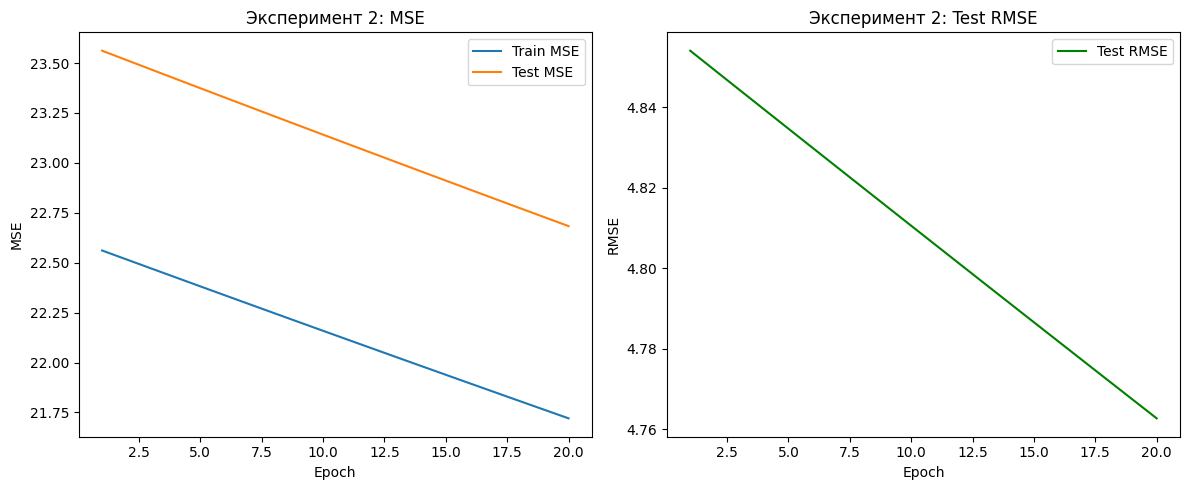

In [26]:
# Эксперимент 2: модифицированная базовая модель с уменьшенным learning rate и увеличенным числом эпох

# Используем тот же срез данных
set_random_seed(42)  # чтобы обеспечить воспроизводимость

# Инициализируем снова модель той же архитектуры
model2 = nn.Linear(X_train_tensor.shape[1], 1).to(device)

# Новые гиперпараметры: снижение learning rate и увеличение числа эпох
learning_rate_exp2 = 5e-4
num_epochs_exp2 = 20

train_losses_exp2 = []
test_losses_exp2 = []
test_rmse_exp2 = []

for epoch in range(num_epochs_exp2):
    model2.train()
    pred_train = model2(X_train_tensor).squeeze()
    loss_train = mse_loss(pred_train, y_train_tensor)
    loss_train.backward()

    with torch.no_grad():
        for param in model2.parameters():
            param -= learning_rate_exp2 * param.grad
            param.grad.zero_()

    train_losses_exp2.append(loss_train.item())

    model2.eval()
    with torch.no_grad():
        pred_test = model2(X_test_tensor).squeeze()
        loss_test = mse_loss(pred_test, y_test_tensor)
        test_losses_exp2.append(loss_test.item())
        rmse = torch.sqrt(loss_test)
        test_rmse_exp2.append(rmse.item())

    print(f"Epoch {epoch+1:2d} | Train MSE: {loss_train.item():.4f} | Test MSE: {loss_test.item():.4f} | Test RMSE: {rmse.item():.4f}")

# График результатов
epochs_exp2 = range(1, num_epochs_exp2+1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_exp2, train_losses_exp2, label="Train MSE")
plt.plot(epochs_exp2, test_losses_exp2, label="Test MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Эксперимент 2: MSE")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_exp2, test_rmse_exp2, label="Test RMSE", color="green")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Эксперимент 2: Test RMSE")
plt.legend()
plt.tight_layout()
plt.show()

Epoch  1 | Train MSE: 26.3961 | Test MSE: 25.6249 | Test RMSE: 5.0621
Epoch  2 | Train MSE: 25.8026 | Test MSE: 25.0459 | Test RMSE: 5.0046
Epoch  3 | Train MSE: 25.2236 | Test MSE: 24.4810 | Test RMSE: 4.9478
Epoch  4 | Train MSE: 24.6587 | Test MSE: 23.9298 | Test RMSE: 4.8918
Epoch  5 | Train MSE: 24.1074 | Test MSE: 23.3919 | Test RMSE: 4.8365
Epoch  6 | Train MSE: 23.5693 | Test MSE: 22.8669 | Test RMSE: 4.7819
Epoch  7 | Train MSE: 23.0440 | Test MSE: 22.3544 | Test RMSE: 4.7280
Epoch  8 | Train MSE: 22.5312 | Test MSE: 21.8540 | Test RMSE: 4.6748
Epoch  9 | Train MSE: 22.0304 | Test MSE: 21.3654 | Test RMSE: 4.6223
Epoch 10 | Train MSE: 21.5414 | Test MSE: 20.8882 | Test RMSE: 4.5704
Epoch 11 | Train MSE: 21.0638 | Test MSE: 20.4221 | Test RMSE: 4.5191
Epoch 12 | Train MSE: 20.5972 | Test MSE: 19.9669 | Test RMSE: 4.4684
Epoch 13 | Train MSE: 20.1414 | Test MSE: 19.5222 | Test RMSE: 4.4184
Epoch 14 | Train MSE: 19.6961 | Test MSE: 19.0877 | Test RMSE: 4.3690
Epoch 15 | Train MSE

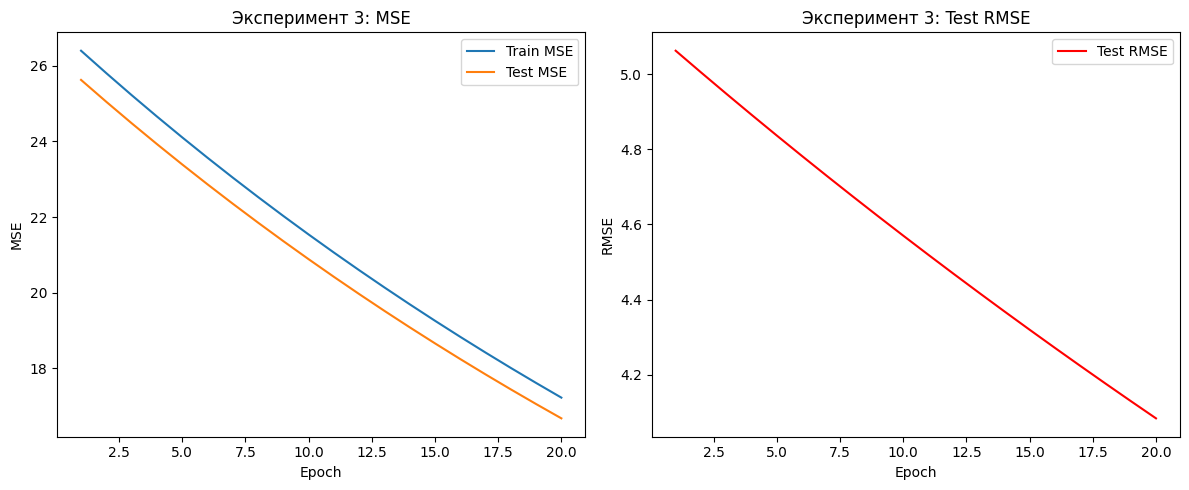

In [22]:
# Эксперимент 3: добавление скрытого слоя с активацией ReLU

set_random_seed(42)

# Определяем модель с одним скрытым слоем
class TwoLayerNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

hidden_dim = 64
model3 = TwoLayerNet(X_train_tensor.shape[1], hidden_dim).to(device)

# Гиперпараметры
learning_rate_exp3 = 1e-3
num_epochs_exp3 = 20

train_losses_exp3 = []
test_losses_exp3 = []
test_rmse_exp3 = []

for epoch in range(num_epochs_exp3):
    model3.train()
    pred_train = model3(X_train_tensor).squeeze()
    loss_train = mse_loss(pred_train, y_train_tensor)
    loss_train.backward()

    with torch.no_grad():
        for param in model3.parameters():
            param -= learning_rate_exp3 * param.grad
            param.grad.zero_()

    train_losses_exp3.append(loss_train.item())

    model3.eval()
    with torch.no_grad():
        pred_test = model3(X_test_tensor).squeeze()
        loss_test = mse_loss(pred_test, y_test_tensor)
        test_losses_exp3.append(loss_test.item())
        rmse = torch.sqrt(loss_test)
        test_rmse_exp3.append(rmse.item())

    print(f"Epoch {epoch+1:2d} | Train MSE: {loss_train.item():.4f} | Test MSE: {loss_test.item():.4f} | Test RMSE: {rmse.item():.4f}")

# График результатов
epochs_exp3 = range(1, num_epochs_exp3+1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_exp3, train_losses_exp3, label="Train MSE")
plt.plot(epochs_exp3, test_losses_exp3, label="Test MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Эксперимент 3: MSE")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_exp3, test_rmse_exp3, label="Test RMSE", color="red")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Эксперимент 3: Test RMSE")
plt.legend()
plt.tight_layout()
plt.show()